In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Data Prepration

In [3]:
# Load dataset
column_names = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
data = pd.read_csv("data_banknote_authentication.txt", header=None, names=column_names)

In [4]:
data.isnull().sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

In [5]:
data.duplicated().sum()

24

In [6]:
data = data.drop_duplicates()

In [7]:
data.duplicated().sum()

0

In [8]:
data.describe()

,variance,skewness,curtosis,entropy,class
count,1348.000000,1348.000000,1348.000000,1348.000000,1348.000000
mean,0.445785,1.909039,1.413578,-1.168712,0.452522
std,2.862906,5.868600,4.328365,2.085877,0.497925
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.786650,-1.627000,-1.545600,-2.393100,0.000000
50%,0.518735,2.334150,0.605495,-0.578890,0.000000
75%,2.853250,6.796025,3.199800,0.403863,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


# Visualization

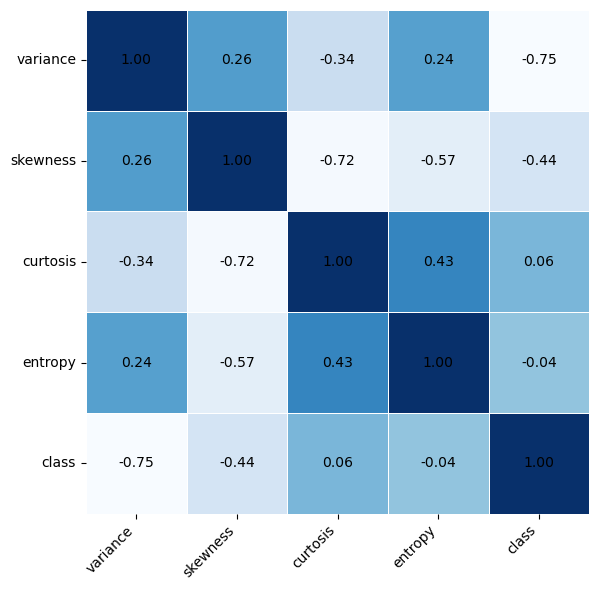

In [10]:
corr = data.corr(method='spearman').round(2)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    corr,
    cmap='Blues',
    cbar=False,     
    linewidths=.5,
    square=True
)

n = corr.shape[0]
for i in range(n):
    for j in range(n):
        ax.text(
            j + 0.5,           
            i + 0.5,           
            f"{corr.iat[i, j]:.2f}",  
            ha="center",       
            va="center",      
            color="black"
        )

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

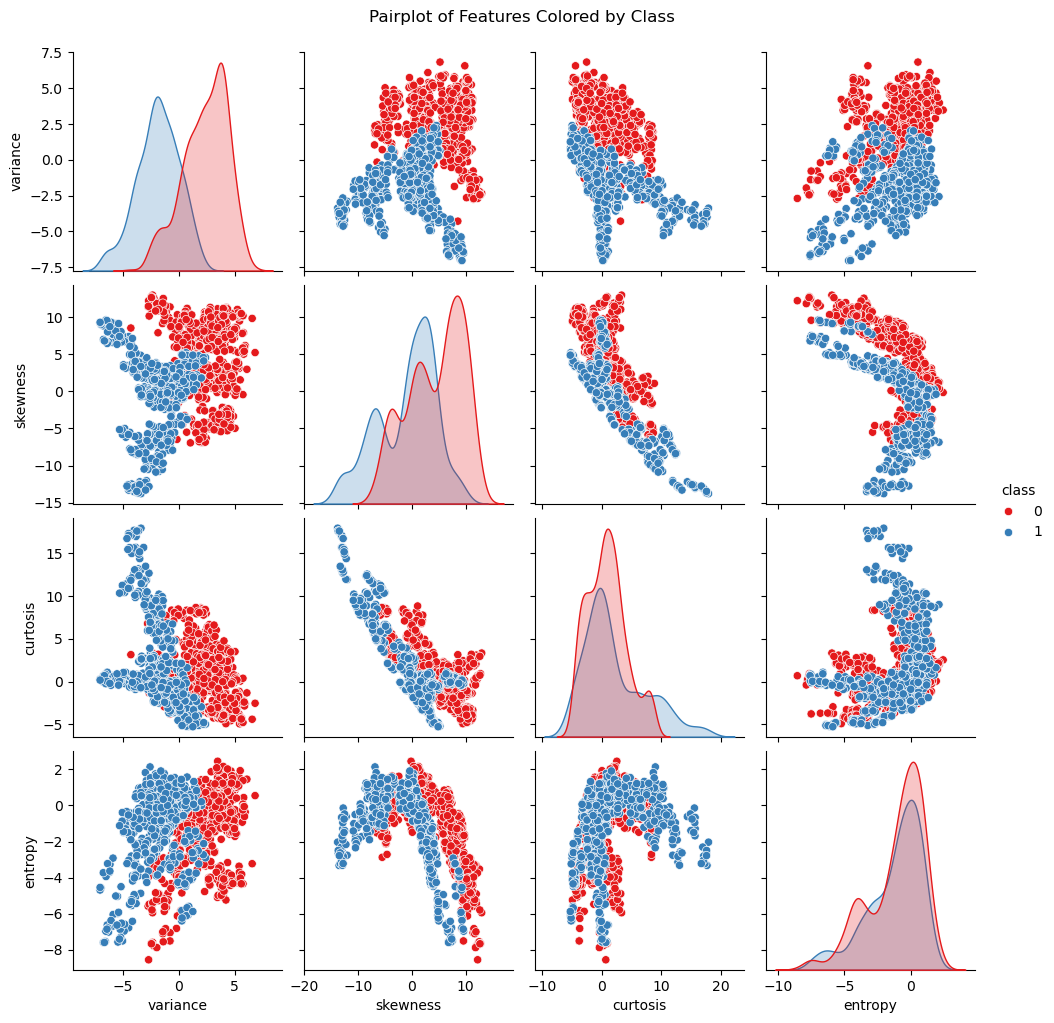

In [11]:
#Pairplot
sns.pairplot(data, hue='class', palette='Set1')
plt.suptitle('Pairplot of Features Colored by Class', y=1.02)
plt.show()

In [12]:
df = data.copy()

# Building SVM (Gradient & Subgradient)

In [14]:
X = df.drop('class', axis=1).values
y = df['class'].values
y = np.where(y == 0, -1, 1)  # convert to -1, 1 for hinge loss

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split: 80% train, 10% val, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# --- Common functions ---
def hinge_loss(w, b, X, y):
    return np.maximum(0, 1 - y * (np.dot(X, w) + b)).mean()

def compute_accuracy(X, y, w, b):
    preds = np.sign(np.dot(X, w) + b).flatten()
    return np.mean(preds == y)

# --- Subgradient Method ---
def subgradient_descent(X, y, X_val, y_val, X_test, y_test, lr=0.01, epochs=100, C=0.01):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    b = 0
    acc_history = []
    val_acc_history = []
    loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        for i in range(n_samples):
            if y[i] * (np.dot(X[i], w) + b) < 1:
                w -= lr * (-C * y[i] * X[i])
                b -= lr * (-C * y[i])

        train_loss = hinge_loss(w, b, X, y)
        train_acc = compute_accuracy(X, y, w, b)
        val_loss = hinge_loss(w, b, X_val, y_val)
        val_acc = compute_accuracy(X_val, y_val, w, b)

        print(f"Epoch {epoch+1:3} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f} | Val Acc: {val_acc:.2f}")
        acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        loss_history.append(train_loss)
        val_loss_history.append(val_loss)

    test_preds = np.sign(np.dot(X_test, w) + b)
    #edit1
    sub_acc = accuracy_score(y_test, test_preds)
    print("\nFinal Test Accuracy:", sub_acc)
    #edit2
    sub_conf_mtx = confusion_matrix(y_test, test_preds)
    print("Confusion Matrix:\n", sub_conf_mtx)
    #edit8
    sub_test_loss = hinge_loss(w, b, X_test, y_test)
    print("Test Loss:", sub_test_loss)


    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(acc_history, label="Train Accuracy")
    plt.plot(val_acc_history, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs (Subgradient)")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Hinge Loss")
    plt.title("Loss Over Epochs (Subgradient)")
    plt.legend()
    plt.grid(True)
    plt.show()
    #edit3
    return w, b, acc_history, val_acc_history, loss_history, val_loss_history, sub_acc, sub_conf_mtx, sub_test_loss

# --- Gradient Method ---
def compute_loss(X, y, w, b, lambda_=0.01):
    margins = 1 - y * (np.dot(X, w) + b).flatten()
    hinge_loss = np.mean(np.maximum(0, margins))
    reg_loss = 0.5 * lambda_ * np.dot(w.T, w).item()
    return hinge_loss + reg_loss

def descend(X, y, w, b, lr, lambda_=0.01):
    dldw = np.zeros_like(w)
    dldb = 0.0
    N = X.shape[0]

    for xi, yi in zip(X, y):
        xi = xi.reshape(-1, 1)
        pred = np.dot(w.T, xi) + b
        margin = 1 - yi * pred
        if margin > 0:
            dldw += -yi * xi
            dldb += -yi

    w = w - lr * ((1/N) * dldw + lambda_ * w)
    b = b - lr * (1/N) * dldb
    return w, b

def gradient_descent(X_train, y_train, X_val, y_val, X_test, y_test, lr=0.01, epochs=100, lambda_=0.01):
    n_features = X_train.shape[1]
    w = np.zeros((n_features, 1))
    b = 0.0
    y_train = y_train.reshape(-1, 1)

    acc_history = []
    val_acc_history = []
    loss_history = []
    val_loss_history = []
    
    for epoch in range(epochs):
        w, b = descend(X_train, y_train, w, b, lr, lambda_)
        train_loss = compute_loss(X_train, y_train, w, b, lambda_)
        train_acc = compute_accuracy(X_train, y_train.flatten(), w, b)
        val_acc = compute_accuracy(X_val, y_val, w, b)
        val_loss = compute_loss(X_val, y_val.reshape(-1, 1), w, b, lambda_)
        
        print(f"Epoch {epoch+1:3} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f} | Val Acc: {val_acc:.2f}")
        acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        loss_history.append(train_loss)
        val_loss_history.append(val_loss)

    y_pred = np.sign(np.dot(X_test, w) + b).flatten()
    #edit4
    grad_acc = accuracy_score(y_test, y_pred)
    print("\nFinal Test Accuracy:", grad_acc)
    #edit5
    grad_conf_mtx = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", grad_conf_mtx)
    #edit7
    grad_test_loss = hinge_loss(w, b, X_test, y_test)
    print("Test Loss:", grad_test_loss)


    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(acc_history, label="Train Accuracy")
    plt.plot(val_acc_history, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs (Gradient)")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Hinge Loss")
    plt.title("Loss Over Epochs (Gradient)")
    plt.legend()
    plt.grid(True)
    plt.show()
    #edit6
    return w, b, acc_history, val_acc_history, loss_history, val_loss_history, grad_acc, grad_conf_mtx, grad_test_loss

Enter training method ('sub' or 'gradient'):  sub


Epoch   1 | Train Loss: 0.9167 | Train Acc: 0.84 | Val Acc: 0.87
Epoch   2 | Train Loss: 0.8333 | Train Acc: 0.84 | Val Acc: 0.87
Epoch   3 | Train Loss: 0.7500 | Train Acc: 0.84 | Val Acc: 0.87
Epoch   4 | Train Loss: 0.6738 | Train Acc: 0.85 | Val Acc: 0.88
Epoch   5 | Train Loss: 0.6097 | Train Acc: 0.85 | Val Acc: 0.88
Epoch   6 | Train Loss: 0.5605 | Train Acc: 0.86 | Val Acc: 0.89
Epoch   7 | Train Loss: 0.5215 | Train Acc: 0.86 | Val Acc: 0.90
Epoch   8 | Train Loss: 0.4890 | Train Acc: 0.86 | Val Acc: 0.90
Epoch   9 | Train Loss: 0.4625 | Train Acc: 0.87 | Val Acc: 0.90
Epoch  10 | Train Loss: 0.4395 | Train Acc: 0.87 | Val Acc: 0.90
Epoch  11 | Train Loss: 0.4193 | Train Acc: 0.88 | Val Acc: 0.90
Epoch  12 | Train Loss: 0.4012 | Train Acc: 0.89 | Val Acc: 0.90
Epoch  13 | Train Loss: 0.3854 | Train Acc: 0.89 | Val Acc: 0.92
Epoch  14 | Train Loss: 0.3714 | Train Acc: 0.90 | Val Acc: 0.92
Epoch  15 | Train Loss: 0.3587 | Train Acc: 0.91 | Val Acc: 0.92
Epoch  16 | Train Loss: 0

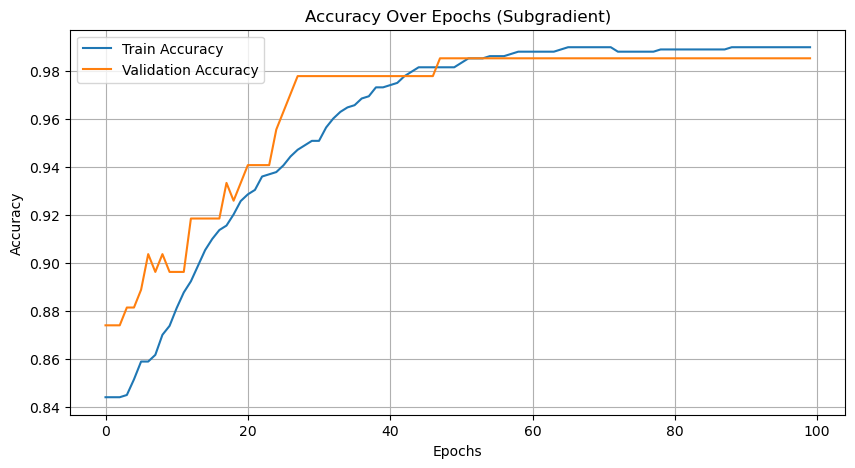

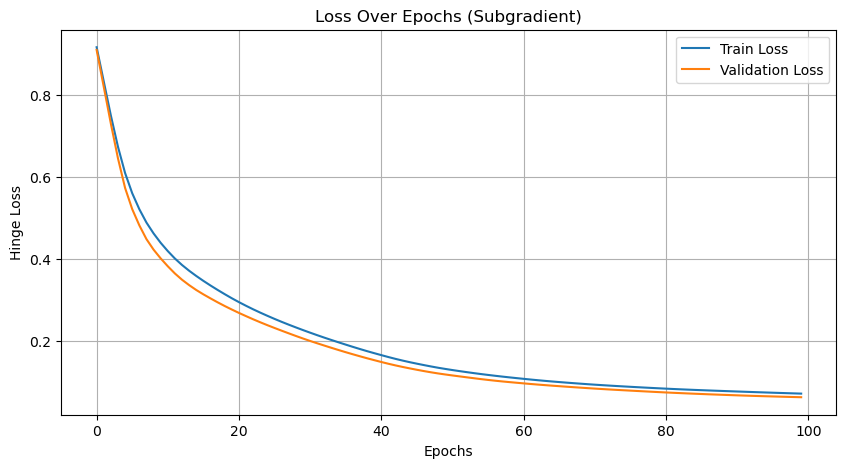

In [15]:
method = input("Enter training method ('sub' or 'gradient'): ").strip().lower()

if method == 'sub':
    w, b, acc_curve, val_acc_curve, loss_curve, val_loss_curve, final_acc, final_conf_mtx, test_loss = subgradient_descent(X_train, y_train, X_val, y_val, X_test, y_test)
elif method == 'gradient':
    w, b, acc_curve, val_acc_curve, loss_curve, val_loss_curve, final_acc, final_conf_mtx, test_loss = gradient_descent(X_train, y_train, X_val, y_val, X_test, y_test)
else:
    print("Invalid method. Please choose 'sub' or 'gradient'.")


Enter training method ('sub' or 'gradient'):  gradient


Epoch   1 | Train Loss: 0.9999 | Train Acc: 0.84 | Val Acc: 0.87
Epoch   2 | Train Loss: 0.9998 | Train Acc: 0.84 | Val Acc: 0.87
Epoch   3 | Train Loss: 0.9997 | Train Acc: 0.84 | Val Acc: 0.87
Epoch   4 | Train Loss: 0.9996 | Train Acc: 0.84 | Val Acc: 0.87
Epoch   5 | Train Loss: 0.9995 | Train Acc: 0.84 | Val Acc: 0.87
Epoch   6 | Train Loss: 0.9994 | Train Acc: 0.84 | Val Acc: 0.87
Epoch   7 | Train Loss: 0.9993 | Train Acc: 0.84 | Val Acc: 0.87
Epoch   8 | Train Loss: 0.9992 | Train Acc: 0.84 | Val Acc: 0.87
Epoch   9 | Train Loss: 0.9991 | Train Acc: 0.84 | Val Acc: 0.87
Epoch  10 | Train Loss: 0.9990 | Train Acc: 0.84 | Val Acc: 0.87
Epoch  11 | Train Loss: 0.9989 | Train Acc: 0.84 | Val Acc: 0.87
Epoch  12 | Train Loss: 0.9988 | Train Acc: 0.84 | Val Acc: 0.87
Epoch  13 | Train Loss: 0.9987 | Train Acc: 0.84 | Val Acc: 0.87
Epoch  14 | Train Loss: 0.9986 | Train Acc: 0.84 | Val Acc: 0.87
Epoch  15 | Train Loss: 0.9985 | Train Acc: 0.84 | Val Acc: 0.87
Epoch  16 | Train Loss: 0

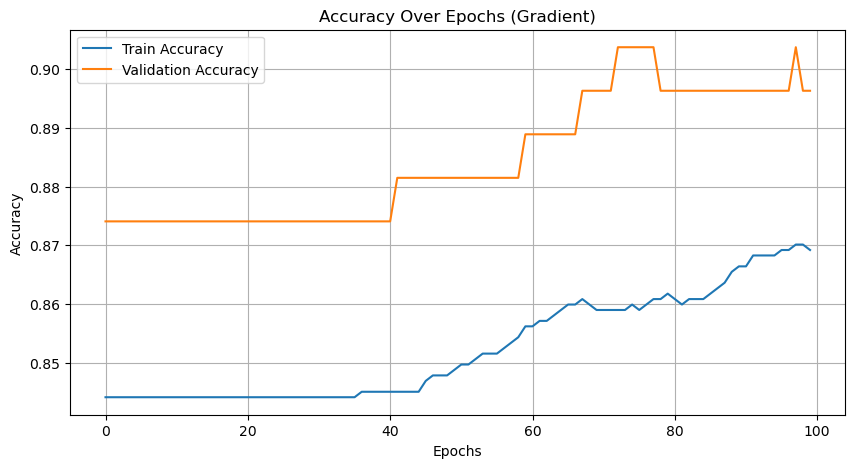

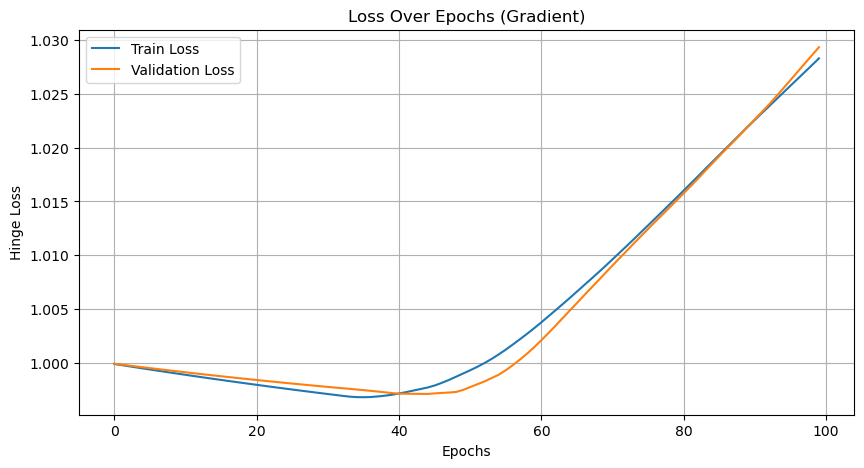

In [16]:
method = input("Enter training method ('sub' or 'gradient'): ").strip().lower()

if method == 'sub':
    w, b, acc_curve, val_acc_curve, loss_curve, val_loss_curve, final_acc, final_conf_mtx, test_loss = subgradient_descent(X_train, y_train, X_val, y_val, X_test, y_test)
elif method == 'gradient':
    w, b, acc_curve, val_acc_curve, loss_curve, val_loss_curve, final_acc, final_conf_mtx, test_loss = gradient_descent(X_train, y_train, X_val, y_val, X_test, y_test)
else:
    print("Invalid method. Please choose 'sub' or 'gradient'.")

<h2 style="
  color: #fff;
  text-shadow: 0 0 5px navy, 0 0 10px navy, 0 0 20px navy, 0 0 40px #0ff;
  font-family: 'Segoe UI', sans-serif;
  margin: 34px;
">
  Analysis
</h2>


<style "color">
Analysis

In [19]:
def SVM(method):
    if method == 'sub':
        return subgradient_descent(X_train, y_train, X_val, y_val, X_test, y_test)
    elif method == 'gradient':
        return gradient_descent(X_train, y_train, X_val, y_val, X_test, y_test)
    else:
        print("Invalid method. Please choose 'sub' or 'gradient'.")

Epoch   1 | Train Loss: 0.9167 | Train Acc: 0.84 | Val Acc: 0.87
Epoch   2 | Train Loss: 0.8333 | Train Acc: 0.84 | Val Acc: 0.87
Epoch   3 | Train Loss: 0.7500 | Train Acc: 0.84 | Val Acc: 0.87
Epoch   4 | Train Loss: 0.6738 | Train Acc: 0.85 | Val Acc: 0.88
Epoch   5 | Train Loss: 0.6097 | Train Acc: 0.85 | Val Acc: 0.88
Epoch   6 | Train Loss: 0.5605 | Train Acc: 0.86 | Val Acc: 0.89
Epoch   7 | Train Loss: 0.5215 | Train Acc: 0.86 | Val Acc: 0.90
Epoch   8 | Train Loss: 0.4890 | Train Acc: 0.86 | Val Acc: 0.90
Epoch   9 | Train Loss: 0.4625 | Train Acc: 0.87 | Val Acc: 0.90
Epoch  10 | Train Loss: 0.4395 | Train Acc: 0.87 | Val Acc: 0.90
Epoch  11 | Train Loss: 0.4193 | Train Acc: 0.88 | Val Acc: 0.90
Epoch  12 | Train Loss: 0.4012 | Train Acc: 0.89 | Val Acc: 0.90
Epoch  13 | Train Loss: 0.3854 | Train Acc: 0.89 | Val Acc: 0.92
Epoch  14 | Train Loss: 0.3714 | Train Acc: 0.90 | Val Acc: 0.92
Epoch  15 | Train Loss: 0.3587 | Train Acc: 0.91 | Val Acc: 0.92
Epoch  16 | Train Loss: 0

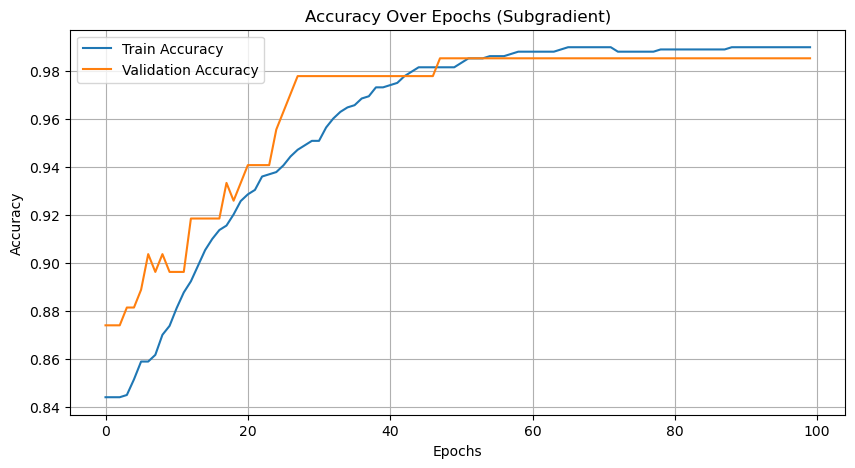

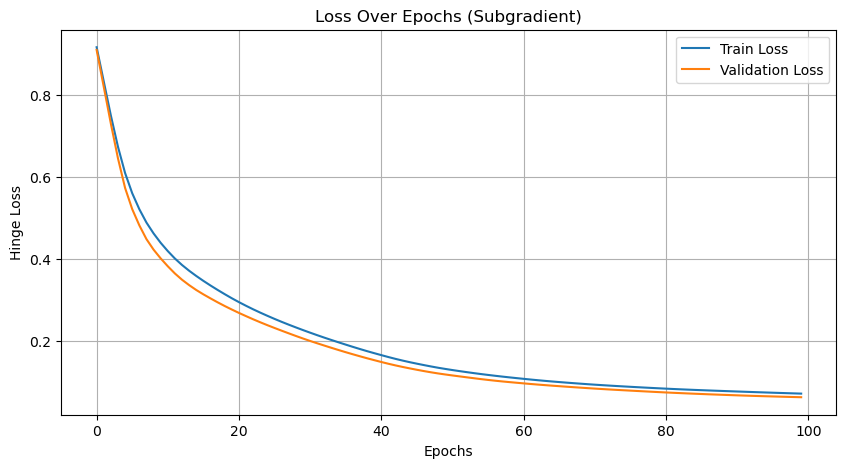

In [20]:
sub_w, sub_b, sub_acc_curve, sub_val_acc_curve, sub_loss_curve, sub_val_loss_curve, sub_acc, sub_conf_mtx, sub_test_loss = SVM("sub")

In [21]:
sub_acc, sub_conf_mtx, sub_test_loss

(0.9851851851851852,
 array([[72,  2],
        [ 0, 61]], dtype=int64),
 0.06038754416090485)

Epoch   1 | Train Loss: 0.9999 | Train Acc: 0.84 | Val Acc: 0.87
Epoch   2 | Train Loss: 0.9998 | Train Acc: 0.84 | Val Acc: 0.87
Epoch   3 | Train Loss: 0.9997 | Train Acc: 0.84 | Val Acc: 0.87
Epoch   4 | Train Loss: 0.9996 | Train Acc: 0.84 | Val Acc: 0.87
Epoch   5 | Train Loss: 0.9995 | Train Acc: 0.84 | Val Acc: 0.87
Epoch   6 | Train Loss: 0.9994 | Train Acc: 0.84 | Val Acc: 0.87
Epoch   7 | Train Loss: 0.9993 | Train Acc: 0.84 | Val Acc: 0.87
Epoch   8 | Train Loss: 0.9992 | Train Acc: 0.84 | Val Acc: 0.87
Epoch   9 | Train Loss: 0.9991 | Train Acc: 0.84 | Val Acc: 0.87
Epoch  10 | Train Loss: 0.9990 | Train Acc: 0.84 | Val Acc: 0.87
Epoch  11 | Train Loss: 0.9989 | Train Acc: 0.84 | Val Acc: 0.87
Epoch  12 | Train Loss: 0.9988 | Train Acc: 0.84 | Val Acc: 0.87
Epoch  13 | Train Loss: 0.9987 | Train Acc: 0.84 | Val Acc: 0.87
Epoch  14 | Train Loss: 0.9986 | Train Acc: 0.84 | Val Acc: 0.87
Epoch  15 | Train Loss: 0.9985 | Train Acc: 0.84 | Val Acc: 0.87
Epoch  16 | Train Loss: 0

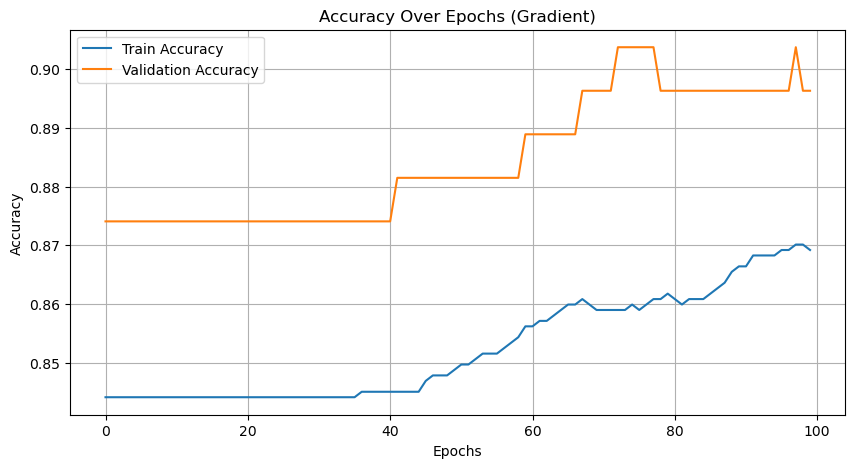

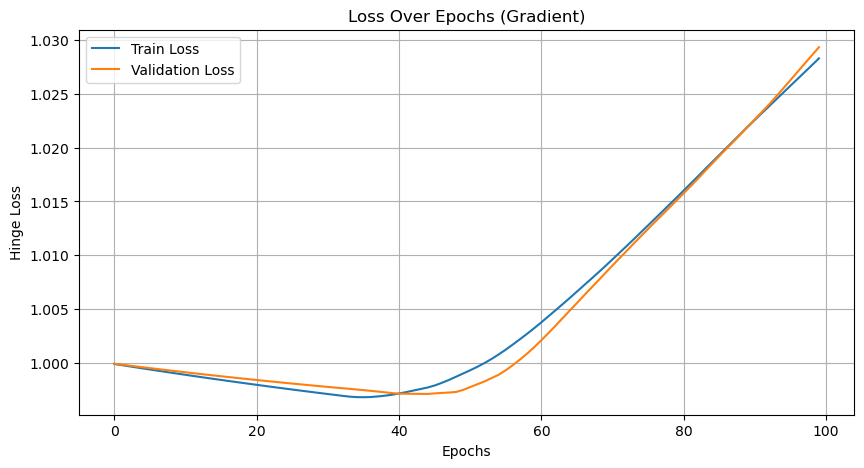

In [22]:
grad_w, grad_b, grad_acc_curve, grad_val_acc_curve, grad_loss_curve, grad_val_loss_curve, grad_acc, grad_conf_mtx, grad_test_loss = SVM("gradient")

In [23]:
grad_acc, grad_conf_mtx, grad_test_loss

(0.8740740740740741,
 array([[63, 11],
        [ 6, 55]], dtype=int64),
 1.0253027300825661)

final accuracy for the model using subgradient method:  0.9851851851851852
final accuracy for the model using the gradient descent method:  0.8740740740740741


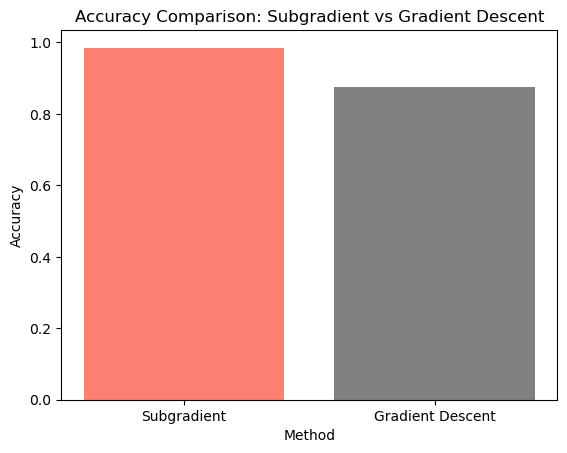

In [24]:
print("final accuracy for the model using subgradient method: ", sub_acc)
print("final accuracy for the model using the gradient descent method: ", grad_acc)

methods = ['Subgradient', 'Gradient Descent']
accuracies = [sub_acc, grad_acc]

plt.bar(methods, accuracies, color=['salmon', 'grey'])
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison: Subgradient vs Gradient Descent')
plt.show()


In [25]:
loss_deltas = np.abs(np.diff(sub_loss_curve))
sub_plateau_epoch = np.argmax(loss_deltas < 1e-3)
sub_plateau_epoch

74

In [26]:
loss_deltas = np.abs(np.diff(grad_loss_curve))
grad_plateau_epoch = np.argmax(loss_deltas < 1e-3)
grad_plateau_epoch

0

In [27]:
max_acc_epoch = np.argmax(sub_acc_curve)
max_acc_epoch

65

In [28]:
max_acc_epoch = np.argmax(grad_acc_curve)
max_acc_epoch

97

In [29]:
max_acc = max(sub_acc_curve)
acc_threshold = 0.95 * max_acc
print(acc_threshold)
acc95_epoch = np.argmax(np.array(sub_acc_curve) >= acc_threshold)
acc95_epoch

0.9403061224489795


25

In [30]:
max_acc = max(grad_acc_curve)
acc_threshold = 0.95 * max_acc
print(acc_threshold)
acc95_epoch = np.argmax(np.array(grad_acc_curve) >= acc_threshold)
acc95_epoch

0.8266233766233766


0

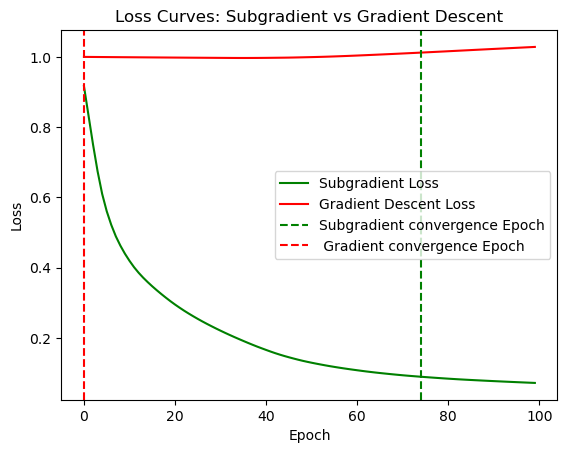

In [31]:
plt.plot(sub_loss_curve, label='Subgradient Loss', color='green')
plt.plot(grad_loss_curve, label='Gradient Descent Loss', color = 'red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves: Subgradient vs Gradient Descent')
plt.axvline(x=sub_plateau_epoch, color='green', linestyle='--', label='Subgradient convergence Epoch')
plt.axvline(x=grad_plateau_epoch, color='red', linestyle='--', label=' Gradient convergence Epoch')
plt.legend()
plt.show()


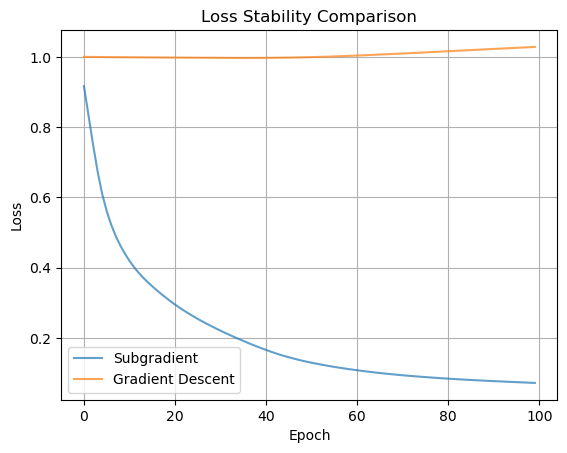

In [32]:
#graphs are enough to compare stability of the loss function (they've been already plotted in the model methods)
plt.plot(sub_loss_curve, label='Subgradient', alpha=0.7)
plt.plot(grad_loss_curve, label='Gradient Descent', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Stability Comparison')
plt.legend()
plt.grid(True)
plt.show()


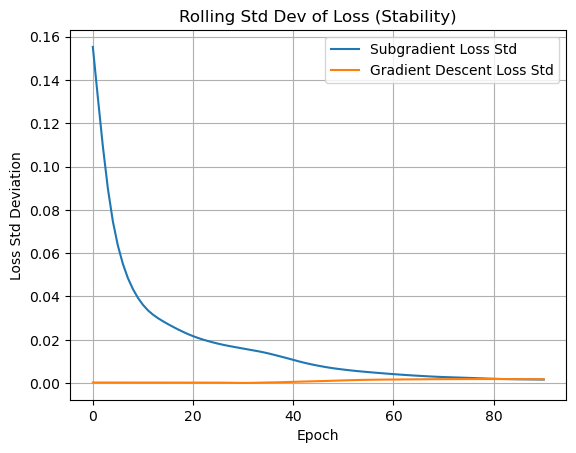

In [33]:
def window_std(curve, window=10):
    return [np.std(curve[i:i+window]) for i in range(len(curve) - window + 1)]

sub_std = window_std(sub_loss_curve)
grad_std = window_std(grad_loss_curve)

plt.plot(sub_std, label='Subgradient Loss Std')
plt.plot(grad_std, label='Gradient Descent Loss Std')
plt.xlabel('Epoch')
plt.ylabel('Loss Std Deviation')
plt.title('Rolling Std Dev of Loss (Stability)')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
print("Test Accuracy(sub):", sub_acc)
print("Test Loss(sub):", sub_test_loss)

Test Accuracy(sub): 0.9851851851851852
Test Loss(sub): 0.06038754416090485


In [35]:
print("Test Accuracy(gradient):", grad_acc)
print("Test Loss(gradient):", grad_test_loss)

Test Accuracy(gradient): 0.8740740740740741
Test Loss(gradient): 1.0253027300825661


In [36]:
print("confusion matrix for subgradient", sub_conf_mtx)
print("confusion matrix for gradient", grad_conf_mtx)

confusion matrix for subgradient [[72  2]
 [ 0 61]]
confusion matrix for gradient [[63 11]
 [ 6 55]]


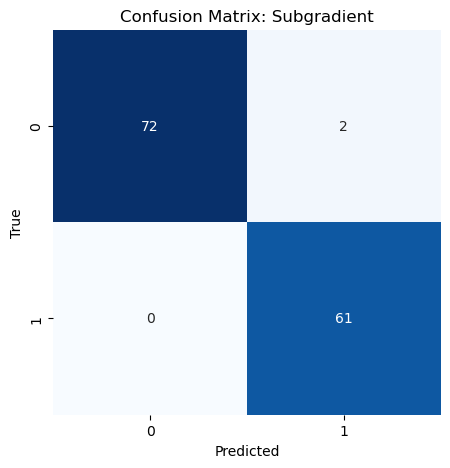

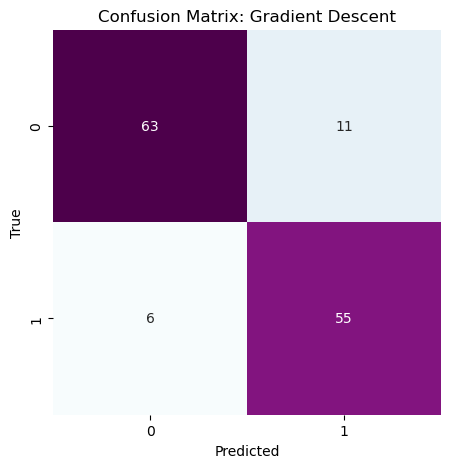

In [37]:
plt.figure(figsize=(5,5))
sns.heatmap(sub_conf_mtx, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Subgradient')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

plt.figure(figsize=(5,5))
sns.heatmap(grad_conf_mtx, annot=True, fmt='d', cmap='BuPu', cbar=False)
plt.title('Confusion Matrix: Gradient Descent')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
